## Project- AirFares
--- -------------------

### A. Introduction
--- -------------------

This project studies the german domestic airfares during the period 25-10-2019 to 24-04-2020 between major airports in Germany. The aim of the project is to apply the techniques of machine learning on the dataset and understand the trends in pricing with respect to the various features such the booking date, departure & arrival cities, departure time etc. 
#### B. Details of dataset:
-- -------------------
1. Source: [https://www.kaggle.com/datasets/darjand/domestic-german-air-fares](https://www.kaggle.com/datasets/darjand/domestic-german-air-fares)
2. Generation mode: web scraping
3. Time period considered: 25-10-2019 to 24-04-2020 (6 months).
4. Total entries: 63,000
5. Features:
    * departure_city: The city from which the flight departs.
    * arrival_city: The city to which the flight arrives.
    * scrape_date: The date when flight price information was retrieved.
    * departure_date: The departure date of the flight (25-10-2019 to 24-04-2020).
    * departure_date_distance: How far in advance (e.g., "1 week") the flight was booked.
    * departure_time: The departure time of the flight.
    * arrival_time: The arrival time of the flight.
    * airline: The airline that operates the flight.
    * stops: The number of layovers or stops during the flight.
    * price (€): The price of the flight ticket in Euros.

#### C. Imports:
-- ----------

In [25]:
#imports
import numpy as np
import pandas as pd
import sklearn.model_selection as ms
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import holidays
import time

pd.set_option('display.max_colwidth', 50)

ModuleNotFoundError: No module named 'seaborn'

#### D. Load the dataset:
-- ------------------

In [3]:
#Load the data set
df = pd.read_csv('./data/German Air Fares.csv');

#### E. Data Understanding:
-- ----------------------

##### E.1 Basic statistics:

In [4]:
#Basic statistics
df.shape;                                           #--> (62626, 10)
df.info();df.isna().sum();                          #--> (No null objects)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62626 entries, 0 to 62625
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   departure_city           62626 non-null  object
 1   arrival_city             62626 non-null  object
 2   scrape_date              62626 non-null  object
 3   departure_date           62626 non-null  object
 4   departure_date_distance  62626 non-null  object
 5   departure_time           62626 non-null  object
 6   arrival_time             62626 non-null  object
 7   airline                  62626 non-null  object
 8   stops                    62626 non-null  object
 9   price (€)                62626 non-null  object
dtypes: object(10)
memory usage: 4.8+ MB


##### E.2 Understanding departure and arrival cities
-- ----------------------

In [5]:
df.departure_city.unique();
# a. Extract departure city name, discard shortform (e.g. DUS Düsseldorf -> Düsseldorf)
df['departure_city'] = df['departure_city'].astype(str).apply(lambda x: x.split()[1] if ' ' in x else x)

df.arrival_city.unique();
# b. Extract arrival city name, discard shortform (e.g. DUS Düsseldorf -> Düsseldorf)
df['arrival_city'] = df['arrival_city'].astype(str).apply(lambda x: x.split()[1] if ' ' in x else x)

# c. Replace departure & arrival cities with their respective rankings
airport_ranking = pd.read_csv("./data/German Airport Ranking.csv")
airport_ranking_dict = dict(
    zip(airport_ranking['Airport'], airport_ranking['Rank']))

df['departure_city'] = df['departure_city'].map(airport_ranking_dict)
df['arrival_city'] = df['arrival_city'].map(airport_ranking_dict)

##### E.2 Conclusion: 
* **ToDos:**
    * *A histogram showing distribution of departure and arrival cities would be interesting.*</font>

##### E.3 Understanding departure and scrape dates
-- ----------------------

In [6]:
# a. Departure dates: Find the departure date frequencies: How spread are they?
dep_dates = pd.to_datetime(df['departure_date'], dayfirst=True);
dep_dates = sorted(dep_dates.unique()); 
dep_dates = pd.Series(dep_dates);
dep_dates.shape;                                    
dep_dates.diff(periods=1).unique();        

# b. Scrape dates: Find the scrape date frequencies: How spread are they?
scrape_dates = pd.to_datetime(df['scrape_date'], dayfirst=True);
scrape_dates = sorted(scrape_dates.unique()); 
scrape_dates = pd.Series(scrape_dates);
scrape_dates.shape;                                    
scrape_dates.diff(periods=1).unique();
# -------------------------------------------------------
# c. Convert all date data into date-time format
df.departure_date = pd.to_datetime(df.departure_date, dayfirst=True);
df.scrape_date = pd.to_datetime(df.scrape_date, dayfirst=True);

# c. Sort the dataframe according to departure dates
df.sort_values(by='departure_date', inplace = True)
#print('Dataframe sorted according to departure date: ',df.departure_date.is_monotonic_increasing); #-> True

#--> Additionally, it was verified that there are no illegal date values.

##### E3: Conclusion: 
* **Departure dates:**
    * 42 unique departure dates
    * departure date frequencies are not unique -> ['1 days', '11 days', '5 days', '44 days', '85 days']
* **Scrape dates:**
    * scrape date frequencies are only from 18-24.10.2019
    * scrape date frequencies are unique -> 1 day

##### E.4 Understanding departure_date_distance
-- ----------------------

In [7]:
df.departure_date_distance.value_counts();           
#--> 
# 6 months    12672
# 6 weeks     11222
# 1 month     10092
# 1 week       9949
# 3 month      9748
# 2 weeks      7850
# 2 week       1093

# Replace vague departure_date_distance (weeks, months etc.) with differences as days 
df.departure_date_distance =  (df['departure_date'] - df['scrape_date']).dt.days

##### E.5 Understanding departure and arrival times
-- ----------------------

In [8]:
# a. Uniformize time formats ('Uhr', am/pm) into xx:xx 24-hour format
def convert_to_24_hour_format(time_str):
    if 'Uhr' in time_str:
        return datetime.strptime(time_str, '%H:%M Uhr').strftime('%H:%M')
    else:
        return datetime.strptime(time_str, '%I:%M%p').strftime('%H:%M')

# Convert departure time column to 24-hour format
df['departure_time'] = df['departure_time'].apply(convert_to_24_hour_format)
df['arrival_time'] = df['arrival_time'].apply(convert_to_24_hour_format)

# Strip only the hour (to make matters simple)
df['departure_time_hour'] = df['departure_time'].apply(lambda x: int(x.split(':')[0]))

##### E.6 Understanding Airlines
-- ---------------------------------------------

In [9]:
# a. Drop rows with 'Mehrere Fluglinien' and 'Multiple airlines'

df = df[~df['airline'].isin(['Mehrere Fluglinien', 'Multiple Airlines'])]
df['airline'] = df['airline'].replace('easyJet', 'EasyJet')

# b. Convert airlines into their respective ranks (numerical representation)
airport_ranking = pd.read_csv("./data/Airline Ranking.csv")
Airline_ranking_dict = dict(
    zip(airport_ranking['airline'], airport_ranking['rank']))

df['airline'] = df['airline'].map(Airline_ranking_dict)

##### E.6 Conclusion:
* **Airlines:**
    * There were 69 'Mehrere Fluglinien' and 153 'Multiple Airlines', these entries were removed.    

##### E.7 Understanding stops
---------------------------------------------

In [10]:
# Stops are converted into numerical values
# 0, 1 and 2 stops.
def countStops(stop):
    if 'direct' in stop:
        return 0
    elif '1' in stop:
        return 1
    elif '2' in stop:
        return 2
    
df['stops'] = df['stops'].apply(countStops)

##### E8. Understanding prices
--------------------------


In [11]:
# a. Rename 'price (€)' to 'price'
df = df.rename(columns={'price (€)': 'price'});

# b. format into int properly
df['price'] = df['price'].str.replace(',', '').astype(int)

##### E.8 Conclusion:
* prices are, of course, the target value

### F. New Features:
-- -----------

##### F.1: Departure weekdays

In [12]:
#  week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6. 
if 'departure_weekday' not in df.columns:
    df.insert(5,'departure_weekday', df.departure_date.dt.weekday)

##### F.2: days_until_a_holiday

In [13]:
# Create a holidays list for Germany for the years 2019 & 2020.
# Only the national holidays as provided by the holidays library are taken into account. They are:
# date	holiday
# 0	    2019-01-01	Neujahr
# 1	    2019-04-19	Karfreitag
# 2	    2019-04-22	Ostermontag
# 3	    2019-05-01	Erster Mai
# 4	    2019-05-30	Christi Himmelfahrt
# 5	    2019-06-10	Pfingstmontag
# 6	    2019-10-03	Tag der Deutschen Einheit
# 7	    2019-12-25	Erster Weihnachtstag
# 8	    2019-12-26	Zweiter Weihnachtstag
#----------------------------------------
# 9	    2020-01-01	Neujahr
# 10	2020-04-10	Karfreitag
# 11	2020-04-13	Ostermontag
# 12	2020-05-01	Erster Mai
# 13	2020-05-21	Christi Himmelfahrt
# 14	2020-06-01	Pfingstmontag
# 15	2020-10-03	Tag der Deutschen Einheit
# 16	2020-12-25	Erster Weihnachtstag
# 17	2020-12-26	Zweiter Weihnachtstag

holiday_list = list(holidays.Germany(years=[2019, 2020]).items())

holidays_df = pd.DataFrame(holiday_list, columns=['date','holiday'])
holidays_df.date = pd.to_datetime(holidays_df.date)

# Sort holidays_df by date
holidays_df = holidays_df.sort_values(by='date')

# Define a function to find the next holiday
def find_next_holiday(departure_date):
    return holidays_df[holidays_df['date'] >= departure_date].iloc[0]['date']

# Apply the function to get the 'next_holiday'
df['next_holiday'] = df['departure_date'].apply(find_next_holiday)

# Calculate the difference between the two dates to get the 'days_until_holiday'
df['days_until_holiday'] = (df['next_holiday'] - df['departure_date']).dt.days

##### F.3: travel_time

In [14]:
# Calculate the difference between departure and arrival times in hours
df['travel_time'] = (pd.to_datetime(df['arrival_time'], format='%H:%M') - pd.to_datetime(df['departure_time'], format='%H:%M')).dt.total_seconds() / 3600

# Normalize the travel time
df['travel_time'] =  df['travel_time'].apply(lambda x: round(x, 2))

### G. Features + Y Dataframe:
-- -----------

In [15]:
df = df.drop(['scrape_date', 'departure_date', 'next_holiday', 'departure_time', 'arrival_time'],axis=1)
df = df[['departure_city', 'arrival_city',	'departure_date_distance',	'departure_weekday', 'departure_time_hour', 'travel_time', 'days_until_holiday', 'airline',	'stops', 'price']]

In [19]:
X = df.drop(columns=['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor
regressor = RandomForestRegressor(
    n_estimators=100, random_state=42)

# Train the regressor on the training data
regressor.fit(X_train, y_train)

# Make predictions on the testing set
predictions = regressor.predict(X_test)

# Evaluate the performance of the regressor (e.g., using mean squared error)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.5f}")

r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2:.5f}")

mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae:.5f}")

Mean Squared Error: 1463.89163
R-squared: 0.95001
Mean Absolute Error: 19.93108


In [33]:
X = df.drop(columns=['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=200, random_state=42)

# Train the regressor on the training data
regressor.fit(X_train, y_train)

# Make predictions on the testing set
predictions = regressor.predict(X_test)

# Evaluate the performance of the regressor (e.g., using mean squared error)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.5f}")

r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2:.5f}")

mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae:.5f}")

result_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
result_df.head()

Mean Squared Error: 1465.85465
R-squared: 0.94995
Mean Absolute Error: 19.91910


,Actual,Predicted
45026,231,177.740000
24207,372,341.282143
62253,352,352.600000
59092,62,72.820000
36939,132,132.320000


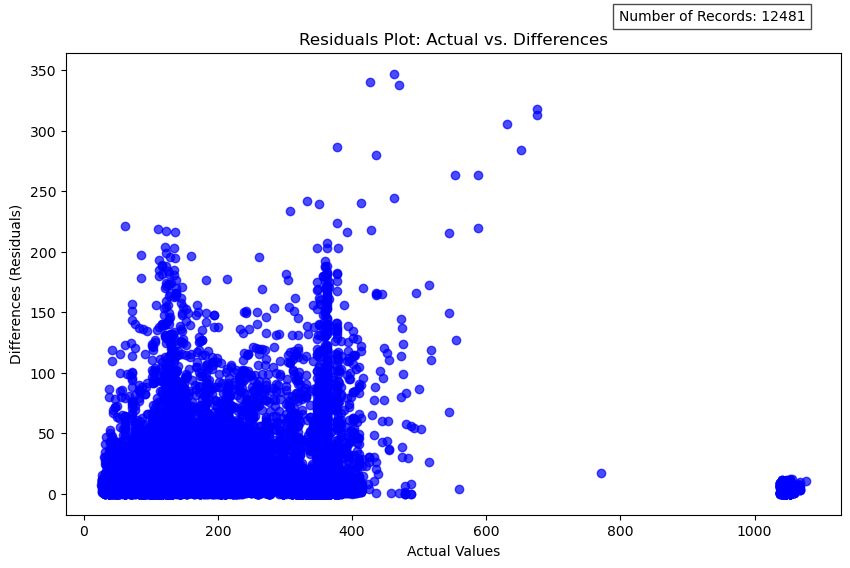

In [41]:
differences = abs(predictions - y_test)

# Create a scatter plot of differences
plt.figure(figsize=(10, 6))
num_records = len(y_test)
plt.text(max(y_test), 400, f'Number of Records: {num_records}', ha='right',
         va='top', color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.scatter(y_test, differences, color='blue', alpha=0.7)
plt.title('Residuals Plot: Actual vs. Differences')
plt.xlabel('Actual Values')
plt.ylabel('Differences (Residuals)')

plt.show()